In [21]:
import optuna
import joblib
import numpy as np
import sys
from tdc.single_pred import ADME
from jazzy.api import molecular_vector_from_smiles as mol_vect
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import fp_from_smiles, HyperparamTuner, tanimoto, create_scatter_plot

In [2]:
model_identifiers = ["linear", "KRR", "GB", "RF", "ANN"]
splitters = ["rand", "scaff", "time"]
data_splits = ["train", "test"]
feature_types = ["morgan", "jazzy"]

# sampler - a method used to generate new sets of hyperparameters in each iteration of the optimization process
samplers = {
    'RandomSampler': optuna.samplers.RandomSampler,          # Sampler that selects hyperparameters randomly from the search space.
    'GridSampler': optuna.samplers.GridSampler,              # Sampler that performs a grid search over the hyperparameter space.
    'TPESampler': optuna.samplers.TPESampler,                # Sampler that uses a tree-structured Parzen estimator to model the objective function and sample new points from the search space.
    'CmaEsSampler': optuna.samplers.CmaEsSampler,            # Sampler that uses the Covariance Matrix Adaptation Evolution Strategy algorithm to efficiently search the hyperparameter space.
    'NSGAIISampler': optuna.samplers.NSGAIISampler,          # Multi-objective evolutionary algorithm that generates new samples using non-dominated sorting and crowding distance selection.
    'QMCSampler': optuna.samplers.QMCSampler,                # Quasi-Monte Carlo sampler that uses low-discrepancy sequences to sample the search space in a more efficient and evenly distributed way than random sampling.
    'BoTorchSampler': optuna.integration.BoTorchSampler,     # Sampler that leverages the BoTorch library for Bayesian optimization and can handle both continuous and categorical hyperparameters.
    'BruteForceSampler': optuna.samplers.BruteForceSampler,  # Sampler that exhaustively evaluates all possible combinations of hyperparameters in the search space.
}
# pruner - a technique used to eliminate unpromising trials during the course of hyperparameter optimization.
pruners = {
    'BasePruner': optuna.pruners.BasePruner,                            # This is the base class for all pruning strategies in Optuna. It provides a skeleton for implementing custom pruning strategies.
    'MedianPruner': optuna.pruners.MedianPruner,                        # A pruner that prunes unpromising trials that have median objective values, as determined in previous steps.
    'SuccessiveHalvingPruner': optuna.pruners.SuccessiveHalvingPruner,  # This pruner repeatedly splits trials into halves, discarding the lower performing half at each iteration.
    'HyperbandPruner': optuna.pruners.HyperbandPruner,                  # This pruner implements the Hyperband algorithm, which selects promising trials and runs them with different resource allocation schemes to determine the best one.
    'PercentilePruner': optuna.pruners.PercentilePruner,                # A pruner that prunes unpromising trials based on their percentile rank relative to all completed trials.
    'NopPruner': optuna.pruners.NopPruner,                              # A pruner that does nothing and does not prune any trials.
    'ThresholdPruner': optuna.pruners.ThresholdPruner,                  # This pruner prunes trials that have not reached a certain level of performance (i.e., objective value).
    'PatientPruner': optuna.pruners.PatientPruner,                      # This pruner prunes trials that do not show improvement over a certain number of steps (or epochs).
}

In [3]:
data = ADME(name='Half_Life_Obach')
split = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
train_smiles = np.array(list(split["train"]["Drug"]) + list(split["valid"]["Drug"]))
train_halflives = np.array(list(split["train"]["Y"]) + list(split["valid"]["Y"]))
test_smiles = np.array(list(split["test"]["Drug"]) + list(split["test"]["Drug"]))
test_halflives = np.array(list(split["test"]["Y"]) + list(split["test"]["Y"]))

reshaped_train_halflife = np.array(train_halflives).reshape(-1, 1)
scaler = MinMaxScaler().fit(reshaped_train_halflife)
train_halflife_scaled = scaler.transform(reshaped_train_halflife)
train_halflives_scaled = np.array([val[0] for val in train_halflife_scaled])

reshaped_test_halflife = np.array(test_halflives).reshape(-1, 1)
scaler = MinMaxScaler().fit(reshaped_test_halflife)
test_halflife_scaled = scaler.transform(reshaped_test_halflife)
test_halflives_scaled = np.array([val[0] for val in test_halflife_scaled])

print(train_smiles.shape, train_halflives_scaled.shape, test_smiles.shape, test_halflives_scaled.shape)

(534,) (534,) (266,) (266,)


In [5]:
train_jazzy_fps = []
train_jazzy_thalfs = []
test_jazzy_fps = []
test_jazzy_thalfs = []

for smi, thalf in zip(train_smiles, train_halflives_scaled):
    try:
        jazzy_fp = mol_vect(smi)
    except:
        jazzy_fp = None
    if jazzy_fp and not np.isnan(np.array(list(jazzy_fp.values()))).any():
        jazzy_fp_list = np.array([fp for fp in jazzy_fp.values()])
        train_jazzy_fps.append(jazzy_fp_list)
        train_jazzy_thalfs.append(thalf)

for smi, thalf in zip(test_smiles, test_halflives_scaled):
    try:
        jazzy_fp = mol_vect(smi)
    except:
        jazzy_fp = None
    if jazzy_fp and not np.isnan(np.array(list(jazzy_fp.values()))).any():
        jazzy_fp_list = np.array([fp for fp in jazzy_fp.values()])
        test_jazzy_fps.append(jazzy_fp_list)
        test_jazzy_thalfs.append(thalf)

Jazzy ERROR: [19:09:07] The RDKit embedding has failed for the molecule: CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3c4cc5cc3Oc3ccc(cc3Cl)[C@@H](O)[C@@H](NC(=O)[C@@H](CC(C)C)NC)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]5C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c5cc(O)c(CNCP(=O)(O)O)c(O)c5-c5cc3ccc5O)[C@H](O)c3ccc(c(Cl)c3)O4)O[C@H](CO)[C@@H](O)[C@@H]2O)O[C@@H](C)[C@H]1O
Jazzy ERROR: [19:09:09] The RDKit embedding has failed for the molecule: CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1ccc(Cl)cc1)C(=O)N[C@H](Cc1cccnc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@H](CCCNC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)N[C@H](C)C(N)=O
Jazzy ERROR: [19:09:31] The RDKit embedding has failed for the molecule: CO[C@@]12CC[C@@]3(C[C@@H]1[C@](C)(O)C(C)(C)C)[C@H]1Cc4ccc(O)c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5
Jazzy ERROR: [19:09:33] The RDKit embedding has failed for the molecule: CCCCCC/C=C\CCCCCCCCCC(=O)N[C@H]1[C@H](OC[C@H]2O[C@H](OP(=O)(O)O)[C@H](NC(=O)CC(=O)CCCCCCCCCCC)[C@@H](

In [6]:
train_jazzy_fps = np.array(train_jazzy_fps)
train_jazzy_thalfs = np.array(train_jazzy_thalfs)
test_jazzy_fps = np.array(test_jazzy_fps)
test_jazzy_thalfs = np.array(test_jazzy_thalfs)
print(train_jazzy_fps.shape, train_jazzy_thalfs.shape, test_jazzy_fps.shape, test_jazzy_thalfs.shape)

(525, 6) (525,) (258, 6) (258,)


In [7]:
train_morgan_fps = np.array(fp_from_smiles(train_smiles))
test_morgan_fps = np.array(fp_from_smiles(test_smiles))
print(train_morgan_fps.shape, test_morgan_fps.shape)

(534, 124) (266, 124)


In [9]:
best_model_hyperparams = {}
for _type in feature_types:
    best_model_hyperparams[_type] = {}
    for model_id in model_identifiers:
        jl = joblib.load(f"project_resources/optuna/obach/{_type}/{model_id}.pkl")
        best_model_hyperparams[_type][model_id] = jl.best_trial.params
print(best_model_hyperparams["morgan"]["linear"])

{'alpha': 0.027898872391050537, 'l1_ratio': 0.9991265276117415}


In [11]:
y_predicted = {}
rmsds = {}
stds = {}
best_models = {}
# test models with the best hyperparams
for _type in feature_types:
    y_predicted[_type] = {}
    rmsds[_type] = {}
    stds[_type] = {}
    best_models[_type] = {}
    group_rmsds = {}
    for model_id in model_identifiers:
        hyperparams = best_model_hyperparams[_type][model_id]
        if _type == "morgan":
            X_train = train_morgan_fps
            y_train = train_halflives_scaled
            X_test = test_morgan_fps
            y_test = test_halflives_scaled

        elif _type == "jazzy":
            X_train = train_jazzy_fps
            y_train = train_jazzy_thalfs
            X_test = test_jazzy_fps
            y_test = test_jazzy_thalfs

        if model_id == 'linear':
            alpha = hyperparams["alpha"]
            l1_ratio = hyperparams["l1_ratio"]
            reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)

        if model_id == 'KRR':
            alpha = hyperparams["alpha"]
            gamma = hyperparams["gamma"]
            kernel = hyperparams["kernel"]
            reg = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)

        if model_id == 'GB':
            n_estimators = hyperparams["n_estimators"]
            learning_rate = hyperparams["learning_rate"]
            max_depth = hyperparams["max_depth"]
            reg = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

        if model_id == 'RF':
            n_estimators = hyperparams["n_estimators"]
            max_features = hyperparams["max_features"]
            max_depth = hyperparams["max_depth"]
            reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)

        if model_id == 'ANN':
            learning_rate_init = hyperparams["learning_rate_init"]
            hidden_layer_sizes = hyperparams["hidden_layer_sizes"]
            reg = MLPRegressor(learning_rate_init=learning_rate_init, hidden_layer_sizes=hidden_layer_sizes)

        # create an instance of HyperparamTuner without specifying any model_identifier
        tuner = HyperparamTuner("foo", X_train, y_train, X_test, y_test)
        # and use the train_test_return function with return_predictions to get the rmsd values
        # predicted y_test
        rmsd, y_test_predictions, std = tuner.train_test_return("foo", reg, return_predictions=True)
        group_rmsds[rmsd] = model_id
        rmsds[_type][model_id] = rmsd
        y_predicted[_type][model_id] = y_test_predictions
        stds[_type][model_id] = std
        print(rmsd, f"y_test predictions: {y_test_predictions[:5]}, {len(y_test_predictions)}")
        print(f"     standard deviations: {std[:4]}, {len(std)}")

    # find best model for each dataset and its rmsd
    min_rmsd = min(group_rmsds.keys())
    best_model = group_rmsds[min_rmsd]
    best_models[_type] = (best_model, min_rmsd)
    print(f"best was {best_model} with rmsd {min_rmsd}")

    print("\n")

0.0639376081269779 y_test predictions: [0.01266174 0.01266174 0.01266174 0.01266174 0.01266174], 266
     standard deviations: [0. 0. 0. 0.], 266
0.06333731350745668 y_test predictions: [0.01263977 0.01263977 0.01263977 0.01263977 0.01263977], 266
     standard deviations: [0. 0. 0. 0.], 266
0.07392981943061368 y_test predictions: [-0.01937683  0.0084096   0.03425236 -0.01352597 -0.00740681], 266
     standard deviations: [1.49897240e-17 7.15244812e-18 4.25861953e-17 1.45482534e-17], 266
0.061329543307512495 y_test predictions: [0.01241499 0.00816789 0.01810225 0.01128589 0.00937188], 266
     standard deviations: [0.00299046 0.00095506 0.00196305 0.00386657], 266
0.06758524186471385 y_test predictions: [0.01765071 0.01765071 0.01765071 0.01765071 0.01765071], 266
     standard deviations: [0.01423923 0.01423923 0.01423923 0.01423923], 266
best was RF with rmsd 0.061329543307512495


0.06504672348942364 y_test predictions: [ 0.02960351 -0.00324246  0.01608838  0.01769178  0.00843406], 

In [15]:
tanimoto_similarities = tanimoto(test_morgan_fps, train_morgan_fps)
median = np.median(tanimoto_similarities)
mean = np.mean(tanimoto_similarities)
print(f"length: {len(tanimoto_similarities)}, median: {median}, arithmetic mean: {mean}, ",
      tanimoto_similarities[:10])

length: 266, median: 0.558, arithmetic mean: 0.5927142857142857,  [0.678, 0.433, 0.528, 0.617, 0.541, 0.6, 0.689, 0.958, 0.625, 0.403]


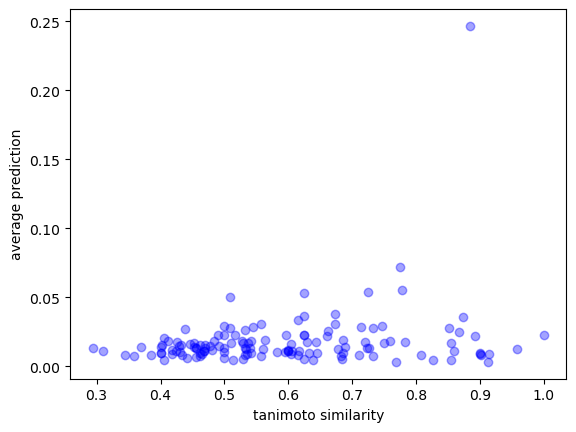

In [20]:
model_id = best_models["morgan"][0]
create_scatter_plot(tanimoto_similarities, y_predicted["morgan"][model_id], "", "tanimoto similarity", "average prediction")

<ErrorbarContainer object of 3 artists>

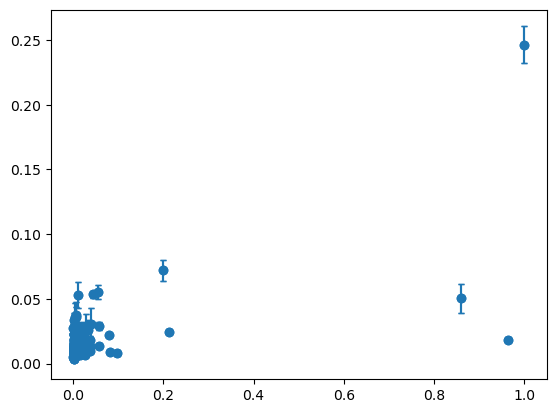

In [26]:
model_id = best_models["morgan"][0]
plt.errorbar(test_halflives_scaled, y_predicted["morgan"][model_id], yerr=stds["morgan"][model_id], fmt="o", capsize=2.0)
plt.errorbar(test_halflives_scaled, y_predicted["morgan"][model_id], yerr=stds["morgan"][model_id], fmt="o", capsize=2.0, )

In [8]:
sampler = samplers['TPESampler']
pruner = pruners["BasePruner"]
n_trials = 200
for _type in feature_types:
    if _type == "morgan":
        X_train = train_morgan_fps
        y_train = train_halflives_scaled
        X_test = test_morgan_fps
        y_test = test_halflives_scaled

    elif _type == "jazzy":
        X_train = train_jazzy_fps
        y_train = train_jazzy_thalfs
        X_test = test_jazzy_fps
        y_test = test_jazzy_thalfs

    for model_identifier in model_identifiers:
        print(model_identifier)
        study = optuna.create_study(study_name=model_identifier, directions=['minimize'], pruner=pruner,
                                    storage=f"sqlite:///project_resources/optuna/obach/{_type}/db.{model_identifier}", load_if_exists=True)
        tuner = HyperparamTuner(model_identifier, X_train, y_train, X_test, y_test)
        study.optimize(tuner.objective, n_trials=n_trials, n_jobs=-1)  # catch=(ValueError,)
        joblib.dump(study, f"./project_resources/optuna/obach/{_type}/{model_identifier}.pkl")

linear


[I 2023-11-01 19:12:13,428] A new study created in RDB with name: linear
[I 2023-11-01 19:12:14,590] Trial 4 finished with value: 0.061336150066223 and parameters: {'alpha': 0.08158722379579608, 'l1_ratio': 0.9288743382867445}. Best is trial 2 with value: 0.05987753450400076.
[I 2023-11-01 19:12:14,594] Trial 3 finished with value: 0.062235653955376 and parameters: {'alpha': 0.04338584780984039, 'l1_ratio': 0.5492592727585415}. Best is trial 2 with value: 0.05987753450400076.
[I 2023-11-01 19:12:14,642] Trial 8 finished with value: 0.06320430157859776 and parameters: {'alpha': 0.09346772544128835, 'l1_ratio': 0.594797755057929}. Best is trial 3 with value: 0.062235653955376.
[I 2023-11-01 19:12:14,650] Trial 0 finished with value: 0.06335404009679617 and parameters: {'alpha': 0.061335772735601576, 'l1_ratio': 0.6531675165516393}. Best is trial 2 with value: 0.05987753450400076.
[I 2023-11-01 19:12:14,725] Trial 2 finished with value: 0.05987753450400076 and parameters: {'alpha': 0.0344

KRR


[I 2023-11-01 19:12:40,172] Trial 7 finished with value: 0.07534384438622127 and parameters: {'alpha': 0.42223921754683597, 'gamma': 7.69641585244449e-15, 'kernel': 'linear'}. Best is trial 3 with value: 0.0750565031970135.
[I 2023-11-01 19:12:40,245] Trial 3 finished with value: 0.0750565031970135 and parameters: {'alpha': 0.9431623326430844, 'gamma': 6.730304865403267e-15, 'kernel': 'rbf'}. Best is trial 2 with value: 0.07421908798927812.
[I 2023-11-01 19:12:40,343] Trial 11 finished with value: 0.07617273131466933 and parameters: {'alpha': 0.11859235551047348, 'gamma': 1.3313967670392945e-15, 'kernel': 'linear'}. Best is trial 3 with value: 0.0750565031970135.
[I 2023-11-01 19:12:40,360] Trial 2 finished with value: 0.07421908798927812 and parameters: {'alpha': 0.36848713117336557, 'gamma': 5.992044595085962e-15, 'kernel': 'laplacian'}. Best is trial 2 with value: 0.07421908798927812.
[I 2023-11-01 19:12:40,405] Trial 6 finished with value: 0.07486008563045604 and parameters: {'alph

GB


[I 2023-11-01 19:13:12,756] Trial 1 finished with value: 0.072970347297289 and parameters: {'n_estimators': 10, 'learning_rate': 0.40113472201589506, 'max_depth': 2}. Best is trial 1 with value: 0.072970347297289.
[I 2023-11-01 19:13:12,888] Trial 3 finished with value: 0.07253049279799366 and parameters: {'n_estimators': 50, 'learning_rate': 0.16750585084691305, 'max_depth': 4}. Best is trial 3 with value: 0.07253049279799366.
[I 2023-11-01 19:13:12,896] Trial 5 finished with value: 0.0712066946752999 and parameters: {'n_estimators': 500, 'learning_rate': 0.11863878540515999, 'max_depth': 5}. Best is trial 5 with value: 0.0712066946752999.
[I 2023-11-01 19:13:13,028] Trial 2 finished with value: 0.07270118436260282 and parameters: {'n_estimators': 500, 'learning_rate': 0.431370029569106, 'max_depth': 4}. Best is trial 5 with value: 0.0712066946752999.
[I 2023-11-01 19:13:13,207] Trial 10 finished with value: 0.073645327443036 and parameters: {'n_estimators': 50, 'learning_rate': 0.248

RF


[I 2023-11-01 19:15:01,693] Trial 4 finished with value: 0.06702558011168086 and parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 3}. Best is trial 4 with value: 0.06702558011168086.
[I 2023-11-01 19:15:01,982] Trial 1 finished with value: 0.06504980186542315 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 10}. Best is trial 1 with value: 0.06504980186542315.
[I 2023-11-01 19:15:02,066] Trial 2 finished with value: 0.06492196313675323 and parameters: {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 5}. Best is trial 2 with value: 0.06492196313675323.
[I 2023-11-01 19:15:02,248] Trial 3 finished with value: 0.06572359244468913 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 10}. Best is trial 2 with value: 0.06492196313675323.
[I 2023-11-01 19:15:02,466] Trial 8 finished with value: 0.0636074645032866 and parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 4}. Best is trial 8 with val

ANN


[I 2023-11-01 19:21:01,234] Trial 2 finished with value: 0.177463151190826 and parameters: {'learning_rate_init': 0.07747124023469551, 'hidden_layer_sizes': [20, 20]}. Best is trial 2 with value: 0.177463151190826.
[I 2023-11-01 19:21:01,454] Trial 4 finished with value: 0.1730361352449913 and parameters: {'learning_rate_init': 0.07819864879832374, 'hidden_layer_sizes': [20, 20]}. Best is trial 4 with value: 0.1730361352449913.
[I 2023-11-01 19:21:01,844] Trial 8 finished with value: 0.1751606493647473 and parameters: {'learning_rate_init': 0.07251828839830116, 'hidden_layer_sizes': [10]}. Best is trial 4 with value: 0.1730361352449913.
[I 2023-11-01 19:21:02,243] Trial 6 finished with value: 0.16457072940581777 and parameters: {'learning_rate_init': 0.06835764084404171, 'hidden_layer_sizes': [5, 5, 5]}. Best is trial 6 with value: 0.16457072940581777.
[I 2023-11-01 19:21:02,311] Trial 7 finished with value: 0.1681810268241182 and parameters: {'learning_rate_init': 0.046509016746111485

linear


[I 2023-11-01 19:26:26,367] Trial 2 finished with value: 0.0627981733157028 and parameters: {'alpha': 0.07930600620959562, 'l1_ratio': 0.7024083814339181}. Best is trial 2 with value: 0.0627981733157028.
[I 2023-11-01 19:26:26,413] Trial 9 finished with value: 0.06298179211998843 and parameters: {'alpha': 0.030936600122903387, 'l1_ratio': 0.6872966075464344}. Best is trial 2 with value: 0.0627981733157028.
[I 2023-11-01 19:26:26,822] Trial 10 finished with value: 0.061058014143379864 and parameters: {'alpha': 0.04553071654380799, 'l1_ratio': 0.365020063811364}. Best is trial 10 with value: 0.061058014143379864.
[I 2023-11-01 19:26:26,879] Trial 8 finished with value: 0.06211411571408943 and parameters: {'alpha': 0.07118435807935813, 'l1_ratio': 0.2725269609823332}. Best is trial 4 with value: 0.0619298946086462.
[I 2023-11-01 19:26:26,977] Trial 4 finished with value: 0.0619298946086462 and parameters: {'alpha': 0.06651076957694388, 'l1_ratio': 0.9112960548121172}. Best is trial 10 wit

KRR


[I 2023-11-01 19:26:52,147] Trial 6 finished with value: 0.06666787957745691 and parameters: {'alpha': 0.637911631120533, 'gamma': 8.843284672704988e-16, 'kernel': 'laplacian'}. Best is trial 2 with value: 0.06162199990221773.
[I 2023-11-01 19:26:52,150] Trial 4 finished with value: 0.06442355225654088 and parameters: {'alpha': 0.9253719672057947, 'gamma': 9.749260759222546e-15, 'kernel': 'rbf'}. Best is trial 2 with value: 0.06162199990221773.
[I 2023-11-01 19:26:52,217] Trial 1 finished with value: 0.06451538089902643 and parameters: {'alpha': 0.30426567747816263, 'gamma': 2.8233202879162865e-15, 'kernel': 'laplacian'}. Best is trial 2 with value: 0.06162199990221773.
[I 2023-11-01 19:26:52,336] Trial 2 finished with value: 0.06162199990221773 and parameters: {'alpha': 0.915646363846707, 'gamma': 8.922615364533431e-15, 'kernel': 'linear'}. Best is trial 2 with value: 0.06162199990221773.
[I 2023-11-01 19:26:52,375] Trial 0 finished with value: 0.06416428742811862 and parameters: {'al

GB


[I 2023-11-01 19:27:23,571] Trial 2 finished with value: 0.06958057046786041 and parameters: {'n_estimators': 200, 'learning_rate': 0.4604310858000388, 'max_depth': 5}. Best is trial 2 with value: 0.06958057046786041.
[I 2023-11-01 19:27:23,735] Trial 6 finished with value: 0.06516638095479825 and parameters: {'n_estimators': 10, 'learning_rate': 0.2478913322236881, 'max_depth': 2}. Best is trial 6 with value: 0.06516638095479825.
[I 2023-11-01 19:27:23,891] Trial 3 finished with value: 0.06581416289553822 and parameters: {'n_estimators': 10, 'learning_rate': 0.1306305676164097, 'max_depth': 3}. Best is trial 6 with value: 0.06516638095479825.
[I 2023-11-01 19:27:24,080] Trial 5 finished with value: 0.07671565094336408 and parameters: {'n_estimators': 500, 'learning_rate': 0.4669179065824191, 'max_depth': 5}. Best is trial 6 with value: 0.06516638095479825.
[I 2023-11-01 19:27:24,082] Trial 0 finished with value: 0.06445780249833521 and parameters: {'n_estimators': 500, 'learning_rate'

RF


[I 2023-11-01 19:28:59,163] Trial 0 finished with value: 0.06658358236930921 and parameters: {'n_estimators': 10, 'max_features': 'auto', 'max_depth': 10}. Best is trial 0 with value: 0.06658358236930921.
[I 2023-11-01 19:28:59,435] Trial 2 finished with value: 0.06981602643332228 and parameters: {'n_estimators': 10, 'max_features': 'auto', 'max_depth': 4}. Best is trial 0 with value: 0.06658358236930921.
[I 2023-11-01 19:28:59,615] Trial 3 finished with value: 0.06634749953803767 and parameters: {'n_estimators': 500, 'max_features': 'auto', 'max_depth': 3}. Best is trial 3 with value: 0.06634749953803767.
[I 2023-11-01 19:28:59,642] Trial 4 finished with value: 0.06917011347716827 and parameters: {'n_estimators': 10, 'max_features': 'log2', 'max_depth': 10}. Best is trial 3 with value: 0.06634749953803767.
[I 2023-11-01 19:28:59,827] Trial 1 finished with value: 0.06472656863066245 and parameters: {'n_estimators': 10, 'max_features': 'auto', 'max_depth': 5}. Best is trial 1 with value

ANN


[I 2023-11-01 19:33:54,266] Trial 9 finished with value: 0.1846028406522111 and parameters: {'learning_rate_init': 0.03422675194450388, 'hidden_layer_sizes': [50, 50]}. Best is trial 9 with value: 0.1846028406522111.
[I 2023-11-01 19:33:58,357] Trial 7 finished with value: 0.18633338233376384 and parameters: {'learning_rate_init': 0.09227337337252116, 'hidden_layer_sizes': [20]}. Best is trial 9 with value: 0.1846028406522111.
[I 2023-11-01 19:33:59,371] Trial 8 finished with value: 0.20343860414435477 and parameters: {'learning_rate_init': 0.012046251271477668, 'hidden_layer_sizes': [20]}. Best is trial 9 with value: 0.1846028406522111.
[I 2023-11-01 19:34:00,257] Trial 4 finished with value: 0.2018132954656625 and parameters: {'learning_rate_init': 0.010576514881132544, 'hidden_layer_sizes': [10, 10, 10]}. Best is trial 9 with value: 0.1846028406522111.
[I 2023-11-01 19:34:00,534] Trial 1 finished with value: 0.24050859614283637 and parameters: {'learning_rate_init': 0.03905542694745